In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import os
import glob
import numpy as np
from skimage.transform import resize
from skimage.io import imsave
from skimage.io import imread

import tensorflow as tf

from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import ModelCheckpoint, CSVLogger
from keras import backend as K
from keras.regularizers import l2
from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
def deform(array, factor, axis):
    stretched = np.repeat(array, np.ceil(factor), axis=axis)
    indices = np.linspace(0, stretched.shape[axis] - 1, int(array.shape[axis] * factor))
    indices = np.rint(indices).astype(int)
    return np.take(stretched, indices, axis=axis)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [3]:
K.set_image_data_format('channels_last')

data_path = './'
project_name = '3D-Unet'
img_depth = 32
img_rows = 256
img_cols =256
smooth = 1.

In [4]:
def get_unet():
    inputs = Input((img_depth, img_rows, img_cols, 1))
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=4)
    conv12 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=4)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conc12)

    conv21 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=4)
    conv22 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conc22)

    conv31 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=4)
    conv32 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=4)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conc32)

    conv41 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=4)
    conv42 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conc42)

    conv51 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=4)
    conv52 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=4)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc52), conc42], axis=4)
    conv61 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=4)
    conv62 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=4)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc62), conv32], axis=4)
    conv71 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=4)
    conv72 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=4)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc72), conv22], axis=4)
    conv81 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=4)
    conv82 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=4)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82), conv12], axis=4)
    conv91 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=4)
    conv92 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=4)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.summary()
    #plot_model(model, to_file='model.png')

    model.compile(optimizer=Adam(lr=2*1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

In [5]:
def train(video, mask):
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet()
    weight_dir = 'weights'
    if not os.path.exists(weight_dir):
        os.mkdir(weight_dir)
    model_checkpoint = ModelCheckpoint(os.path.join(weight_dir, project_name + '.h5'), monitor='val_loss', save_best_only=True)

    log_dir = 'logs'
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    csv_logger = CSVLogger(os.path.join(log_dir,  project_name + '.txt'), separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    history = model.fit(video[:-2], mask[:-2], batch_size=1, epochs=15, verbose=1, shuffle=True, validation_split=0.20, callbacks=[model_checkpoint, csv_logger])
    
    print(history.history.keys())
    
    plt.figure(figsize=(12,8))
    plt.plot(history.history['dice_coef'], label='Train Dice Coefficient')
    plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
    plt.title('Dice Coefficient over time during training')
    plt.ylabel('Dice Coefficient')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    plt.show()

    
    print('-'*30)
    print('Training finished')
    print('-'*30)
    
    # predicting in training function for rapid prototyping

In [6]:
# preprocessing: glue two video together, get a validation set, reshape them into the right input shapes...
input1 = np.swapaxes(np.load('input_1.npz')['arr_0'], 1, 3)
input2 = np.swapaxes(np.load('input_2.npz')['arr_0'], 1, 3)

mask1 = np.swapaxes(np.load('terminal_mask_1.npz')['arr_0'], 1, 3)
mask2 = np.swapaxes(np.load('terminal_mask_2.npz')['arr_0'], 1, 3)

input1 = deform(input1, img_depth/input1.shape[1], axis=1)
input1 = deform(input1, img_rows/input1.shape[2], axis=2)
input1 = deform(input1, img_cols/input1.shape[3], axis=3)

input2 = deform(input2, img_depth/input2.shape[1], axis=1)
input2 = deform(input2, img_rows/input2.shape[2], axis=2)
input2 = deform(input2, img_cols/input2.shape[3], axis=3)

mask1 = deform(mask1, img_depth/mask1.shape[1], axis=1)
mask1 = deform(mask1, img_rows/mask1.shape[2], axis=2)
mask1 = deform(mask1, img_cols/mask1.shape[3], axis=3)

mask2 = deform(mask2, img_depth/mask2.shape[1], axis=1)
mask2 = deform(mask2, img_rows/mask2.shape[2], axis=2)
mask2 = deform(mask2, img_cols/mask2.shape[3], axis=3)

video = np.concatenate((input1, input2), axis=0)
mask = np.concatenate((mask1, mask2), axis=0)

video = np.expand_dims(video, axis=4)
mask = np.expand_dims(mask, axis=4)

video = video.astype('float32')
mask = mask.astype('float32')

In [7]:
L=[]

for i in range(537):
    if mask[i].sum()!=0:
        L.append(i)

In [8]:
video = video[L,:,:,:,:]
mask = mask[L,:,:,:,:]

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 32, 256, 256, 896         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 32, 256, 256, 0           input_1[0][0]                    
                                                                 conv3d_1[0][0]               

Train on 428 samples, validate on 107 samples
Epoch 1/15
428/428 [==============================] - 488s 1s/step - loss: -0.1656 - dice_coef: 0.1656 - val_loss: -0.7171 - val_dice_coef: 0.7171
Epoch 2/15
428/428 [==============================] - 479s 1s/step - loss: -0.8350 - dice_coef: 0.8350 - val_loss: -0.8644 - val_dice_coef: 0.8644
Epoch 3/15
428/428 [==============================] - 480s 1s/step - loss: -0.8808 - dice_coef: 0.8808 - val_loss: -0.8687 - val_dice_coef: 0.8687
Epoch 4/15
428/428 [==============================] - 480s 1s/step - loss: -0.9012 - dice_coef: 0.9012 - val_loss: -0.8712 - val_dice_coef: 0.8712
Epoch 5/15
428/428 [==============================] - 480s 1s/step - loss: -0.9000 - dice_coef: 0.9000 - val_loss: -0.8824 - val_dice_coef: 0.8824
Epoch 6/15
428/428 [==============================] - 480s 1s/step - loss: -0.9144 - dice_coef: 0.9144 - val_loss: -0.8912 - val_dice_coef: 0.8912
Epoch 7/15
428/428 [==============================] - 480s 1s/step - los

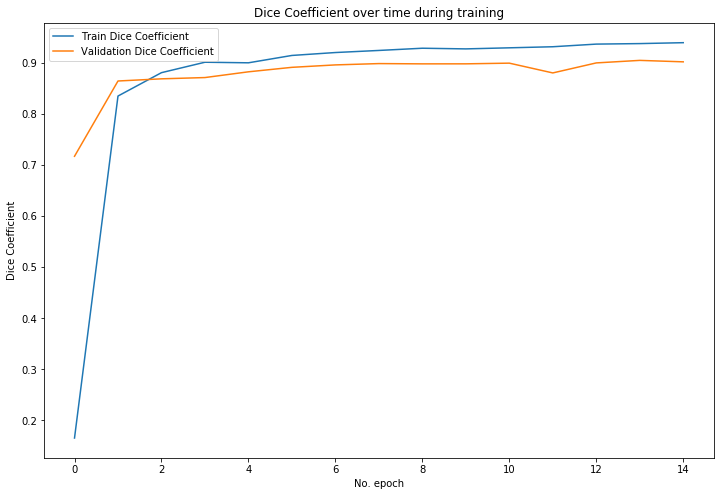

------------------------------
Training finished
------------------------------


In [9]:
train(video, mask)

In [10]:
model = get_unet()
weight_dir = 'weights'
if not os.path.exists(weight_dir):
    os.mkdir(weight_dir)
model.load_weights(os.path.join(weight_dir, project_name + '.h5'))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32, 256, 256, 0                                            
__________________________________________________________________________________________________
conv3d_20 (Conv3D)              (None, 32, 256, 256, 896         input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_23 (Concatenate)    (None, 32, 256, 256, 0           input_2[0][0]                    
                                                                 conv3d_20[0][0]                  
__________________________________________________________________________________________________
conv3d_21 (Conv3D)              (None, 32, 256, 256, 28544       concatenate_23[0][0]       

In [12]:
prediction1 = model.predict(video[-2:], batch_size=1, verbose=1)

2/2 [==============================] - 1s 320ms/step


In [13]:
np.savez('central_mask', mask[-2:])

----------------------------------------------------------------------------------------------------------------------------

In [14]:
volume = video[-2,:,:,:,0]
truth = mask[-2,:,:,:,0]

pred = prediction1[0,:,:,:,0]

print(volume.shape,truth.shape,pred.shape)

(32, 256, 256) (32, 256, 256) (32, 256, 256)


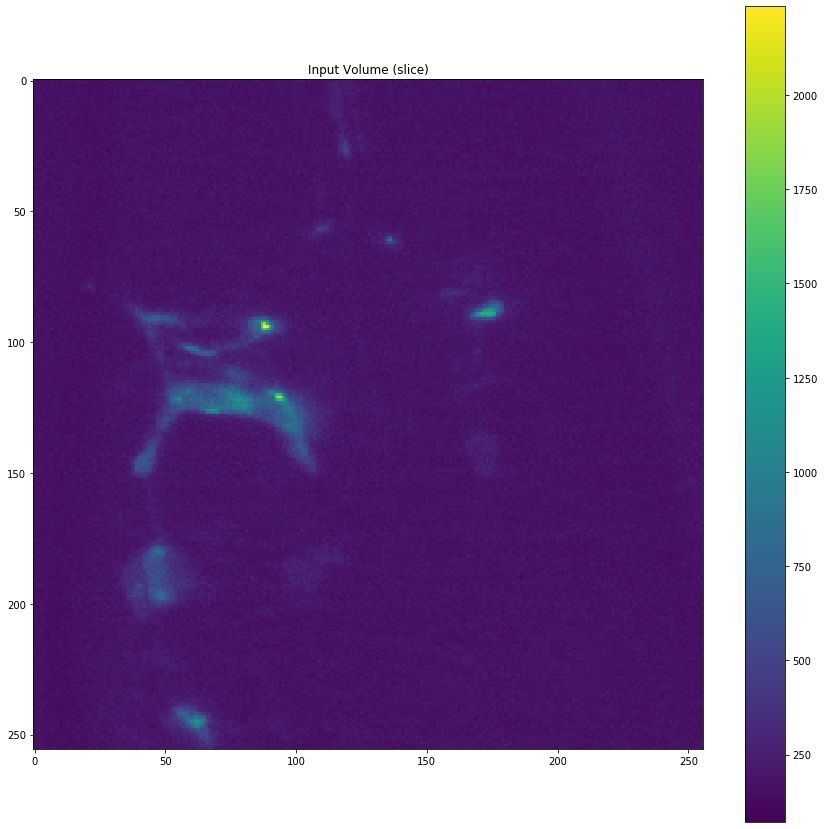

In [15]:
plt.figure(figsize=(15,15))
plt.title('Input Volume (slice)')
plt.imshow(volume[10,:,:])
plt.colorbar()

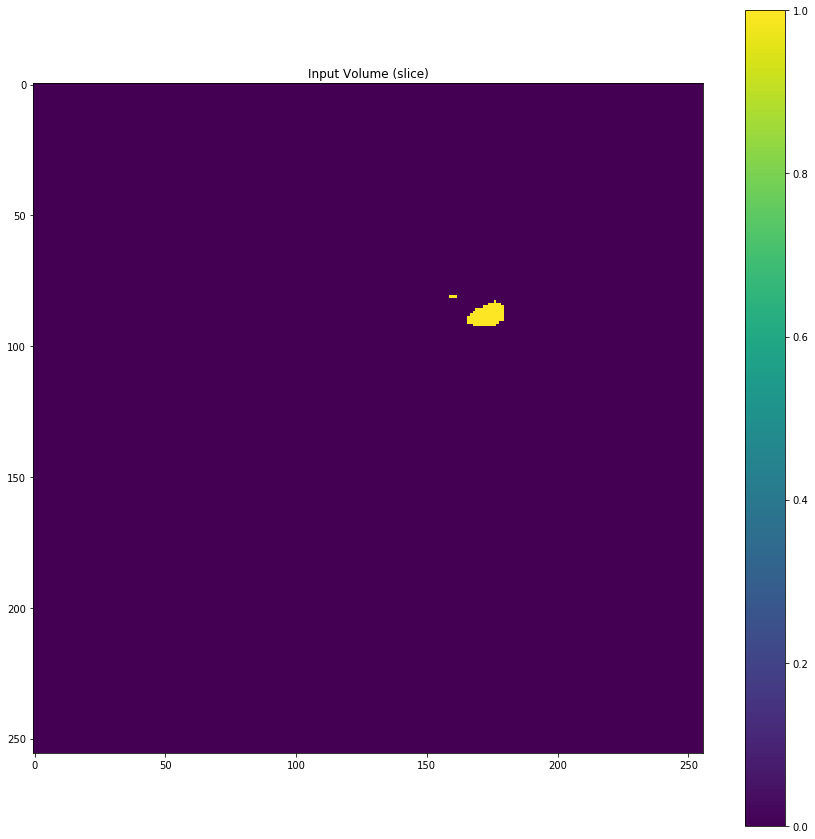

In [16]:
plt.figure(figsize=(15,15))
plt.title('Input Volume (slice)')
plt.imshow(truth[10,:,:])
plt.colorbar()

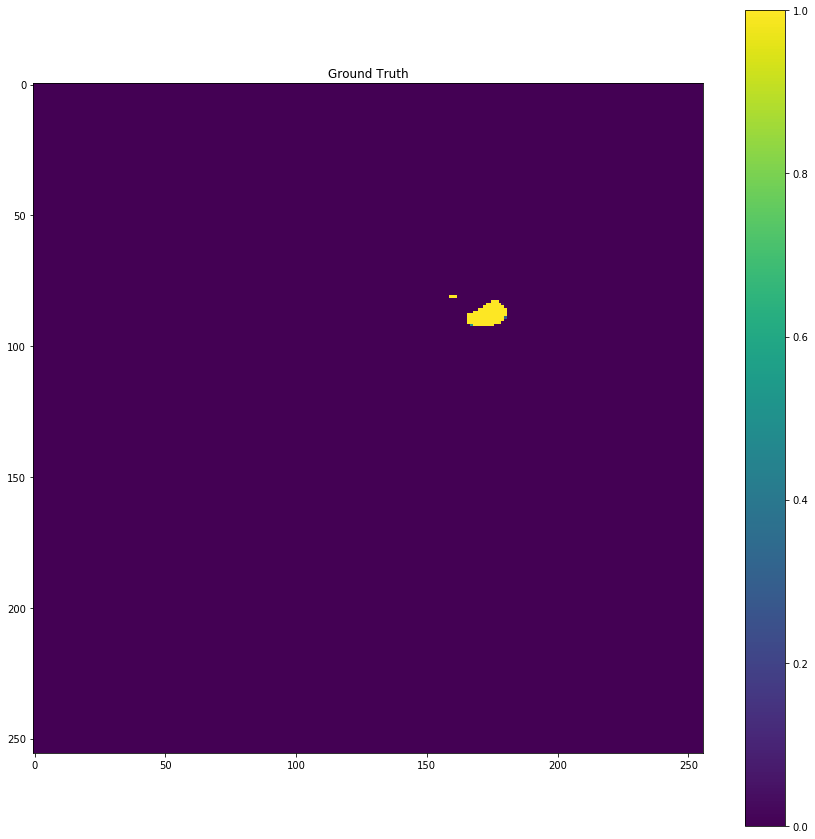

In [17]:
plt.figure(figsize=(15,15))
plt.title('Ground Truth')
plt.imshow(pred[10,:,:])
plt.colorbar()

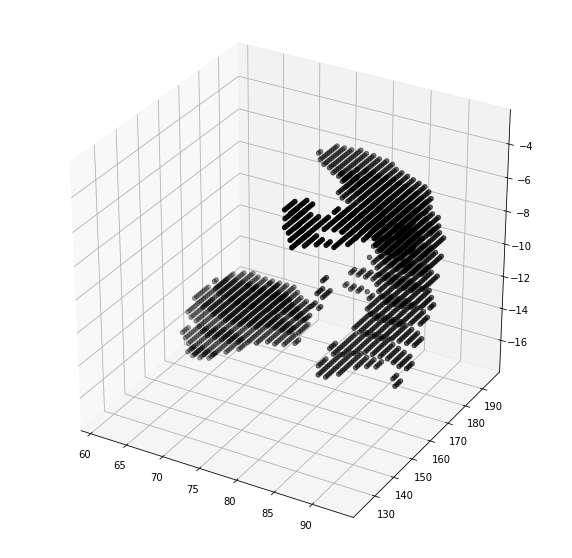

In [18]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

z,x,y = truth.nonzero()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')

In [19]:
tresh = pred>0.9

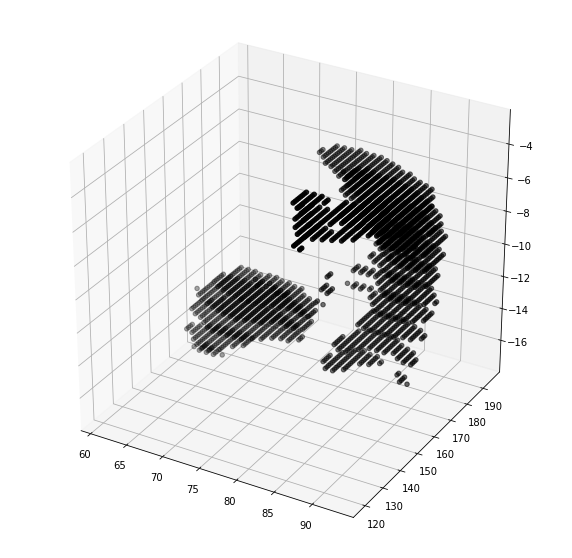

In [20]:
z,x,y = tresh.nonzero()

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, -z, zdir='z', c= 'black')